In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from sqlalchemy import create_engine
import warnings
from tqdm import tqdm
from scipy import stats

In [2]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(15,5)}
        )

# Задание 3

In [4]:
def autolabel(rects, labels=None, height_factor=1.01):
    """вспомогательная функция для печати значений"""
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            try:
                label = '%d' % int(height)
            except:
                label = '%d' % int(0)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label),
                ha='center', va='bottom')

In [5]:
db_config = {'user': 'challenge_user', # имя пользователя
             'pwd': 'aT00GAh944YU4Q1J4zbzryW6Yrz11iq54coz', # пароль
             'host': 'rc1a-eqy3nymy2wp6tbx2.mdb.yandexcloud.net', # адрес сервера
             'port': 6432, # порт подключения
             'db': 'data-analyst-challenge'}# название базы данных
 
# Формируем строку соединения с БД.
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                             db_config['pwd'],
                                             db_config['host'],
                                             db_config['port'],
                                             db_config['db'])
# Подключаемся к БД.
engine = create_engine(connection_string)

In [10]:
# Формируем sql-запрос.
query = ''' with start_studies as ( select user_id
                                      , min(flt.date_created) as first_lesson     
                                from finished_lesson_test as flt
                                join lesson_index_test as lit
                                    on flt.lesson_id = lit.lesson_id 
                                where lit.profession_name = 'data-analyst'                              
                                group by user_id
                               ) , 
             all_deltas as (    select  EXTRACT(EPOCH FROM (lead(flt.date_created) over 
                                                                    (partition by flt.user_id order by flt.date_created ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING )
                                                    - flt.date_created))  as delta_seconds 
                                        , flt.date_created as lesson_datetime
                                        --, flt.lesson_id
                                        , lead(flt.lesson_id) over (partition by flt.user_id order by flt.date_created ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING ) 
                                            as lesson_id
                                        , lead(flt.date_created) over (partition by flt.user_id order by flt.date_created ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING ) 
                                                    as next_lesson_datetime
                                        , lit.profession_name 
                                        , flt.user_id
                                from finished_lesson_test as flt
                                join lesson_index_test as lit
                                    on flt.lesson_id  = lit.lesson_id 
                                join start_studies as ss
                                    on flt.user_id = ss.user_id 
                                       and ss.first_lesson at time zone 'Europe/Moscow' between '2020-04-01' and '2020-05-01'   
                                        -- считаю, что условие по времени (апрель) актуально для Московского времени
                                where lit.profession_name = 'data-analyst'   
                                )
        select  round(cast(delta_seconds as numeric), 0) as delta_seconds 
                , lesson_datetime
                , lesson_id
                , next_lesson_datetime
                , profession_name
                , user_id
                , case when delta_seconds <= 5 then 1 else 0 end as is_fast  -- в финальной выдаче будут значения дельта равные 5, хотя на самом деле они больше 5 (из-за округления до целых), этот флаг поможет найти реальные значения меньше или равно 5
        from all_deltas
        --where delta_seconds <= 5
        '''

# Выполняем запрос и сохраняем результат
# выполнения в DataFrame.
# Sqlalchemy автоматически установит названия колонок
# такими же, как у таблицы в БД.
df = pd.io.sql.read_sql(query, con=engine)

In [11]:
df = df.astype({'delta_seconds': 'Int64'})

In [12]:
df.head(2)

,delta_seconds,lesson_datetime,lesson_id,next_lesson_datetime,profession_name,user_id,is_fast
0,50,2020-04-30 10:54:16.141993+00:00,a9c9b940-ac6e-4c12-89ee-b3fd0f90cf17,2020-04-30 10:55:06.052780+00:00,data-analyst,493,0
1,107,2020-04-30 10:55:06.052780+00:00,e08ec00b-2bf1-449a-ba94-5e1dc6fd948b,2020-04-30 10:56:52.853025+00:00,data-analyst,493,0


In [13]:
df.shape

(173824, 7)

In [14]:
df_fast = df[df.is_fast == 1]

**Из всех значений delta_seconds (173824) для данной когорты и специальности - 506 отвечают условию меньше или равно 5 секунд:**
    

In [13]:
df.is_fast.value_counts()

0    173318
1       506
Name: is_fast, dtype: int64

Относительно общего числа это небольшая доля

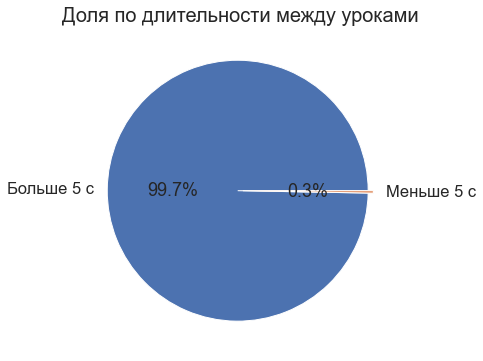

In [28]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Больше 5 с', 'Меньше 5 с']
plt.pie(x=df.is_fast.value_counts(), autopct="%.1f%%" , explode=[0.02]*2
        , labels=labels, pctdistance=0.5 )
plt.title("Доля по длительности между уроками", fontsize=20);

Для интереса посмотрим гистограмму распределения по длительности между двумя уроками (для наглядности возьмем значения меньше 600 - 10 минут)

''

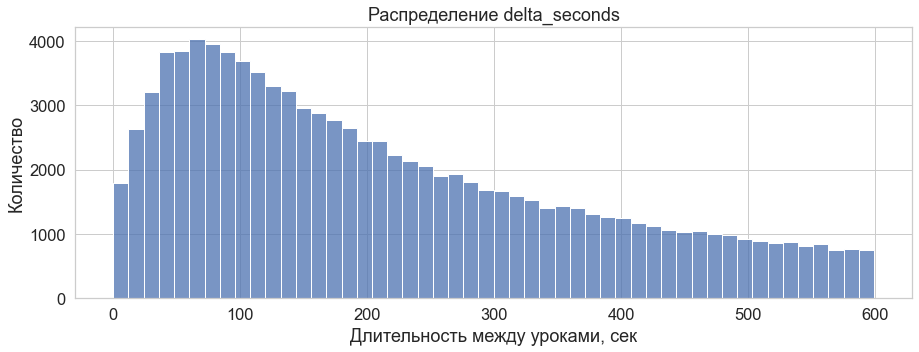

In [16]:
ax = sns.histplot(x='delta_seconds', data=df[df.delta_seconds < 600], bins=50)
ax.set_ylabel('Количество') 
ax.set_xlabel('Длительность между уроками, сек')
ax.set_title('Распределение delta_seconds')
;

Пик распределения в районе значений 50-150 секунд

Если же смотреть на интересующие нас данные, со значениями меньше 5 с, то можно отметить, что больше всего там будет нулевых значений

''

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


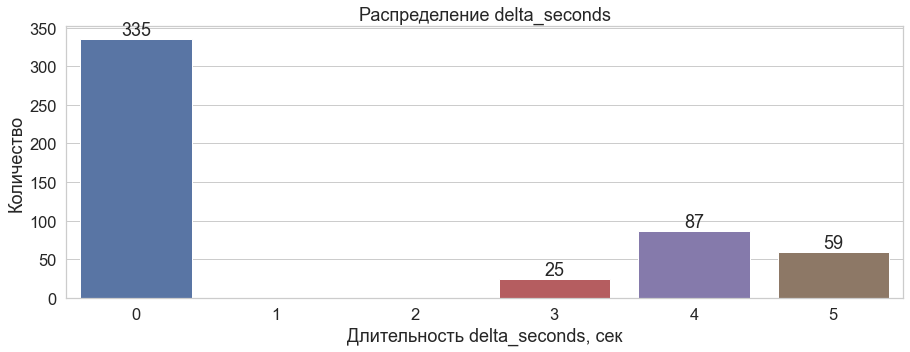

In [17]:
#sns.set_theme(style="darkgrid")
ax = sns.countplot(x="delta_seconds", data=df_fast, order=list(range(df_fast.delta_seconds.min()
                                                                     , df_fast.delta_seconds.max()+1)))
autolabel(ax.patches, height_factor=1)
ax.set_ylabel('Количество') 
ax.set_xlabel('Длительность delta_seconds, сек')
ax.set_title('Распределение delta_seconds')
;

Уникальных уроков, которые так быстро закончились - 93 (всего уникальных уроков для данной когорты 94)

In [18]:
df_fast.lesson_id.nunique()

93

**Наиболее часто встречаются следующие уроки (не стал выводить все уроки, только наиболее частые):**

In [19]:
frequent = df_fast.lesson_id.value_counts().head(10)
frequent

2fb8f1df-6e9a-4b1f-86ff-ca213ef98cc7    50
dbb9697d-3d32-4b81-ad1c-c9ac0496ee39    21
3891bd65-5ff9-4355-b886-f5796ce6ba72    19
cec6f205-490c-4e36-8167-53db63585876    17
2e49d062-d360-47e4-ab55-887c8e79d7d9    15
cc57bb5d-707b-4466-8c6b-651d9447dfe5    13
47cf9db0-4be1-412e-80f7-a3971b6b3c88    13
d8447ed8-0b62-4107-8b6a-10ce6fd8fbd7    13
27039113-5c1f-4175-bdef-d42be07068e9    12
0d0b0084-5e94-41d2-b31a-2d3e56913f6f    11
Name: lesson_id, dtype: int64

''

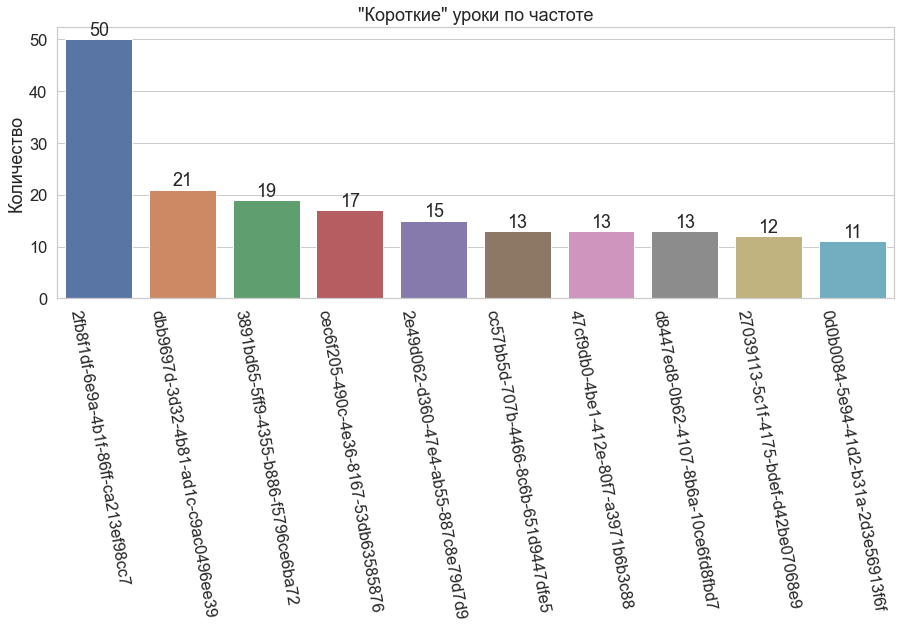

In [22]:
ax = sns.barplot(x=frequent.index, y=frequent)
plt.xticks(rotation=-80)
ax.set_ylabel('Количество') 
ax.set_title('"Короткие" уроки по частоте')
autolabel(ax.patches, height_factor=1)
;

Стоит еще посмотреть, сколько пользователей подвержены этой проблеме. **Их около 1% от всех**

In [23]:
df.user_id.nunique()

9898

In [24]:
df_fast.user_id.nunique()

114

In [48]:
fast_users = df[df.user_id.isin(df_fast.user_id.values)]

In [53]:
fast_users.is_fast.value_counts()

0    6858
1     506
Name: is_fast, dtype: int64

**При этом для этих пользователей почти в 7% случаев случаются такие короткие промежутки между уроками**

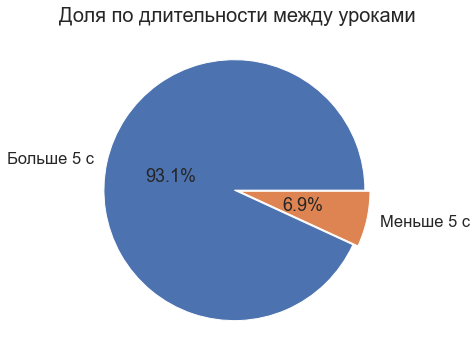

In [51]:
#Using matplotlib
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Больше 5 с', 'Меньше 5 с']
plt.pie(x=fast_users.is_fast.value_counts(), autopct="%.1f%%" , explode=[0.02]*2
        , labels=labels, pctdistance=0.5 )
plt.title("Доля по длительности между уроками", fontsize=20);

''

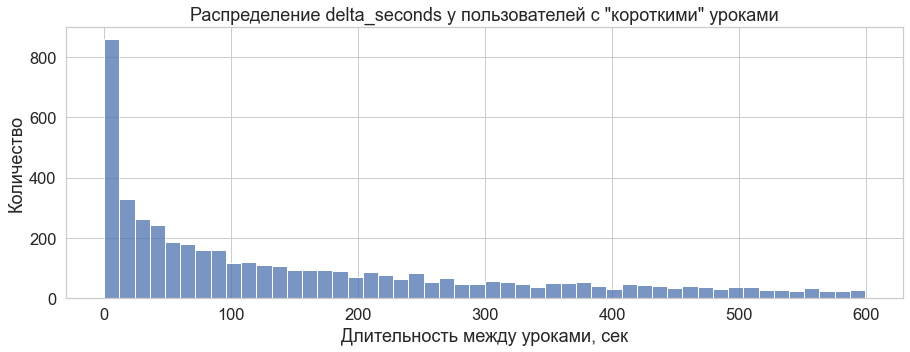

In [52]:
ax = sns.histplot(x='delta_seconds', data=fast_users[fast_users.delta_seconds < 600], bins=50)
ax.set_ylabel('Количество') 
ax.set_xlabel('Длительность между уроками, сек')
ax.set_title('Распределение delta_seconds у пользователей с "короткими" уроками')
;

**Возможно, проблему нужно искать в этих пользователях**

# Задание 4

Коллеги, найден баг в логах о прохождении пользователями уроков, когда для одного пользователя от конца одного урока до конца следующего урока проходит ультра короткое время (меньше 5 секунд, в том числе почти ноль). Проверил на данных по специальности Дата аналитика апрельской когорты. Проблеме подвержен примерно 1% юзеров, и для них таких случаев около 7%, то есть в 7% случаев они проходят урок меньше, чем за 5 секунд. Пока думаю, надо искать причину в этих пользователях

# Задание 5

### Ответы на вопросы

**Как правильно рассчитать размер выборки для АВ-теста?**

С помощью калькулятора на основе входных данных:
- размер эффекта, который мы хотим зафиксировать
- базовая конверсия в интересующее нас действие (например в покупку)
- уровень статистической значимости

**Что должна включать в себя постановка задачи на проведение эксперимента?**

Выбор метрик для контроля, формулирование нулевой и альтернативной гипотез. Оценка эффекта, который мы хотим зафиксировать.

**Как определяются метрики эксперимента? Какими свойствами должны обладать метрики эксперимента?**

Зависит от этапа жизненного цикла продукта и текущих целей. На начальном этапе упор может делаться на метрики связанные с привлечением и удержанием пользователей, например retention. Позже более значимыми могут стать метрики, связанные с монетизацией (конверсия, средний доход на пользователя)

### Задача

**Проверяем нулевую гипотезу о равенстве средней выручки для групп А и В**

In [22]:
orders = pd.read_csv('orders.csv')
orders.head(2)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


In [23]:
visitors = pd.read_csv('visitors.csv')
visitors.head(2)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


Визуализируем, как изменялось среднее значение метрики по дням для двух групп

''

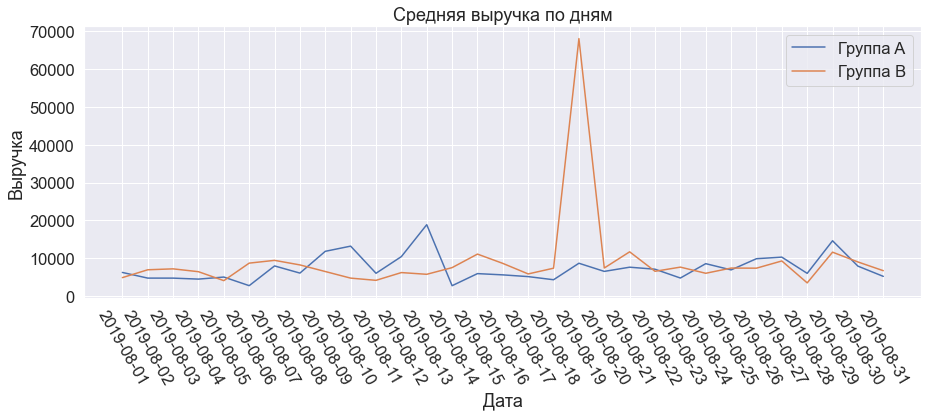

In [151]:
sns.set(font_scale=1.5)
day_mean = orders.groupby(['date', 'group'], as_index=False) \
                  .revenue.mean()

for group in ['A', 'B']:
    ax = sns.lineplot(data=day_mean[day_mean.group == group],  x='date', y='revenue', label=f'Группа {group}')    
ax.set_ylabel('Выручка')
ax.set_xlabel('Дата')
ax.set_title('Средняя выручка по дням')
plt.xticks(rotation=-60)
;  

В группе В есть выбросы, в том числе один выброс, который в 15 раз превышает максимумальную выручку в группе А (из-за одного этого выброса 19 августа пик на графике):    

In [104]:
orders_b[orders_b.revenue == orders_b.revenue.max()]

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B


Тем не менее в остальном средняя дневная выручка изменяется похожим образом и визуально группы А и В не отличаются

In [59]:
# разделим тест и контроль
orders_a = orders[orders.group == 'A']
orders_b = orders[orders.group == 'B']

Данные в обеих группах распределены не нормально

''

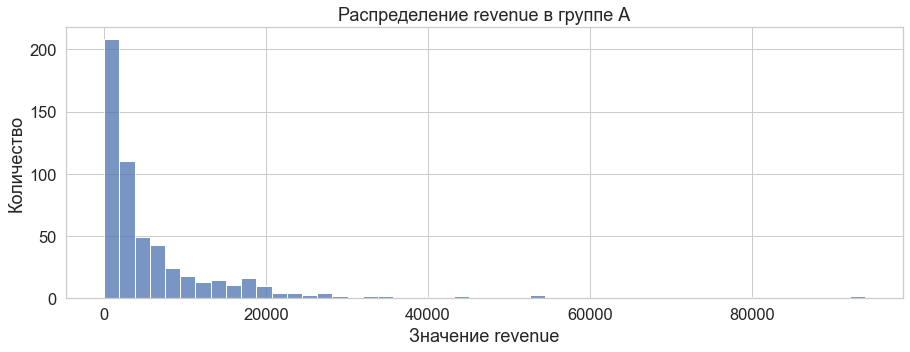

In [85]:
ax = sns.histplot(x='revenue', data=orders_a, bins=50)
ax.set_ylabel('Количество') 
ax.set_xlabel('Значение revenue')
ax.set_title('Распределение revenue в группе А')
;

''

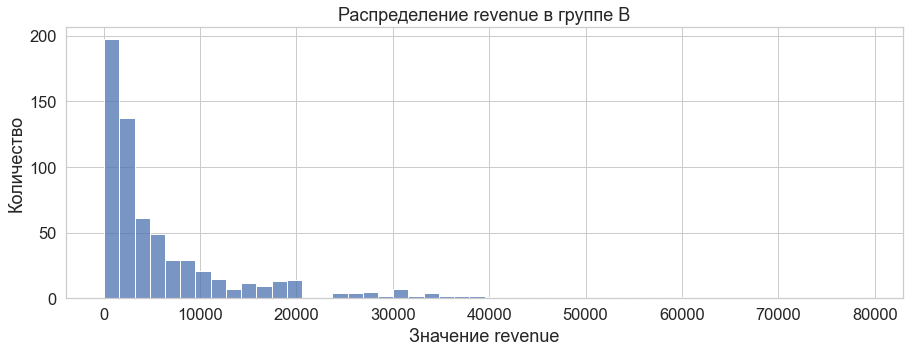

In [88]:
ax = sns.histplot(x='revenue', data=orders_b[orders_b.revenue < 80000], bins=50)
ax.set_ylabel('Количество') 
ax.set_xlabel('Значение revenue')
ax.set_title('Распределение revenue в группе В')
;

Проверим гипотезу о равенстве дисперсий с помощью критерия Левена:    

In [98]:
stat, p = stats.levene(orders_a.revenue, orders_b.revenue)
p

0.4200200892235182

Несмотря на выбросы можно говорить о равенстве дисперсий

Для оценки  воспользуемся критерием Манна-Уитни, который устойчив к выбросам:

In [102]:
stats.mannwhitneyu(orders_a.revenue, orders_b.revenue)

MannwhitneyuResult(statistic=176175.0, pvalue=0.7292909855432458)

**Критерий не позволяет отвергнуть нулевую о равенстве средних, значение pvalue=0.72. 
Таким образом, мы не можем говорить о статистически значимых различиях между группами и предлагать внедрять нововведения**